In [1]:
import os
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import psycopg2
import pandas as pd
import geopandas as gpd
from geopandas import plotting
from shapely import wkb
import geocube
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
import rioxarray
import xarray as xr
import sys

In [2]:
# Database connection parameters
db_params = {
    "host": "",
    "port": "",
    "database": "",
    "user": "",
    "password": ""
}
# Connect to the database
conn = psycopg2.connect(**db_params)
cur = conn.cursor()

In [4]:
# Define SQL Query to join tables
query = """  
    SELECT g.id, g.cell, a.geom, a.name_1, c.final_01, c.final_02, c.final_03, 
           c.final_04, c.final_05, c.final_06, c.final_07, c.final_08, c.final_09, 
           c.final_10, c.final_11, c.final_12
    FROM public.grid_005dd AS g
    JOIN thematic.gadm4_admin_level1_boundaries AS a ON ST_Intersects(g.cell, a.geom) AND a.name_1 = 'Mandera'
    JOIN rainfall_deficit.grid_005dd_chirps AS c ON g.id = c.g005d_id
    where c.year=2022;
"""

In [5]:
# Execute the query and fetch the data
cur.execute(query)
data = cur.fetchall()

In [6]:
# Convert the fetched data into a DataFrame
column_names = ["grid_id", "geometry", "a_geom", "county_name", "final_01", "final_02", "final_03", 
                "final_04", "final_05", "final_06", "final_07", "final_08", "final_09", 
                "final_10", "final_11", "final_12"]  # Add columns as needed
df = pd.DataFrame(data, columns=column_names)

# Convert the 'g005d_id' column to integer
df['grid_id'] = df['grid_id'].astype(int)

# Remove duplicate rows based on 'grid_id'
df = df.drop_duplicates(subset=['grid_id'])

# Reset the index after dropping duplicates
df = df.reset_index(drop=True)

In [7]:
print(df)

      grid_id                                           geometry  \
0    15935328  0106000020E61000000100000001030000000100000005...   
1    15859719  0106000020E61000000100000001030000000100000005...   
2    15924535  0106000020E61000000100000001030000000100000005...   
3    15953325  0106000020E61000000100000001030000000100000005...   
4    15848931  0106000020E61000000100000001030000000100000005...   
..        ...                                                ...   
924  15917329  0106000020E61000000100000001030000000100000005...   
925  15920921  0106000020E61000000100000001030000000100000005...   
926  15848921  0106000020E61000000100000001030000000100000005...   
927  15942532  0106000020E61000000100000001030000000100000005...   
928  15856121  0106000020E61000000100000001030000000100000005...   

                                                a_geom county_name  final_01  \
0    0103000020E610000001000000EF01000048110000667E...     Mandera       1.0   
1    0103000020E6100000

In [8]:
# Convert WKB to Shapely geometry for 'cell' and 'a'
df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x, hex=True))
df['a_geom'] = df['a_geom'].apply(lambda x: wkb.loads(x, hex=True))

In [9]:
# Create GeoDataFrames for 'cell' and 'a'
gdf = gpd.GeoDataFrame(df, geometry='geometry')
a = gpd.GeoDataFrame(df, geometry='a_geom')

C:\Users\admin\AppData\Local\Temp\ipykernel_6904\3299201482.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_tick_labels)
C:\Users\admin\AppData\Local\Temp\ipykernel_6904\3299201482.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)
C:\Users\admin\AppData\Local\Temp\ipykernel_6904\3299201482.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_tick_labels)
C:\Users\admin\AppData\Local\Temp\ipykernel_6904\3299201482.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels)
C:\Users\admin\AppData\Local\Temp\ipykernel_6904\3299201482.py:35: UserWarni

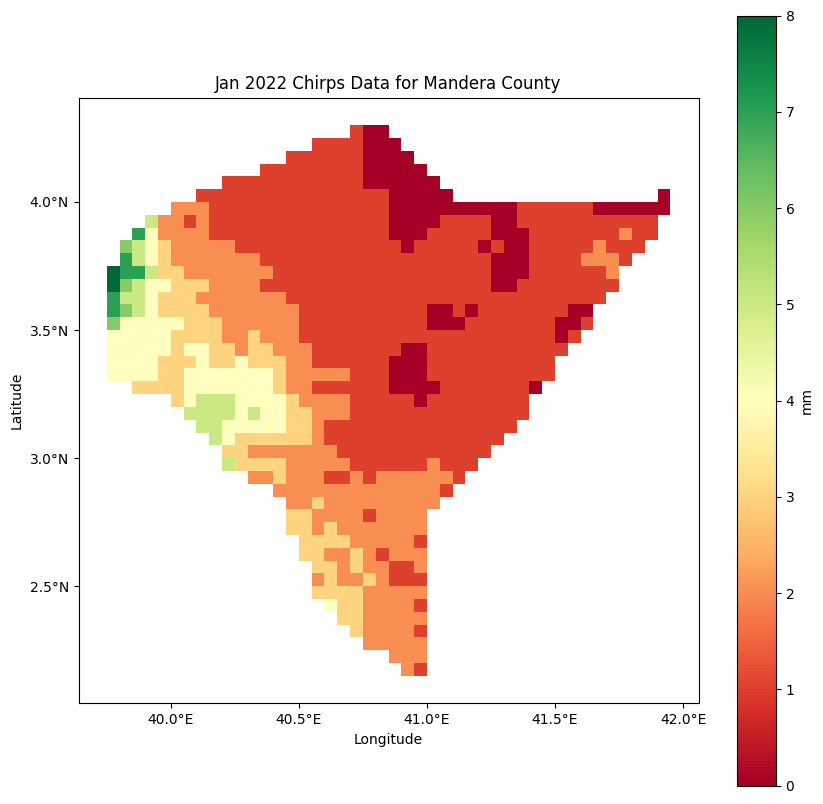

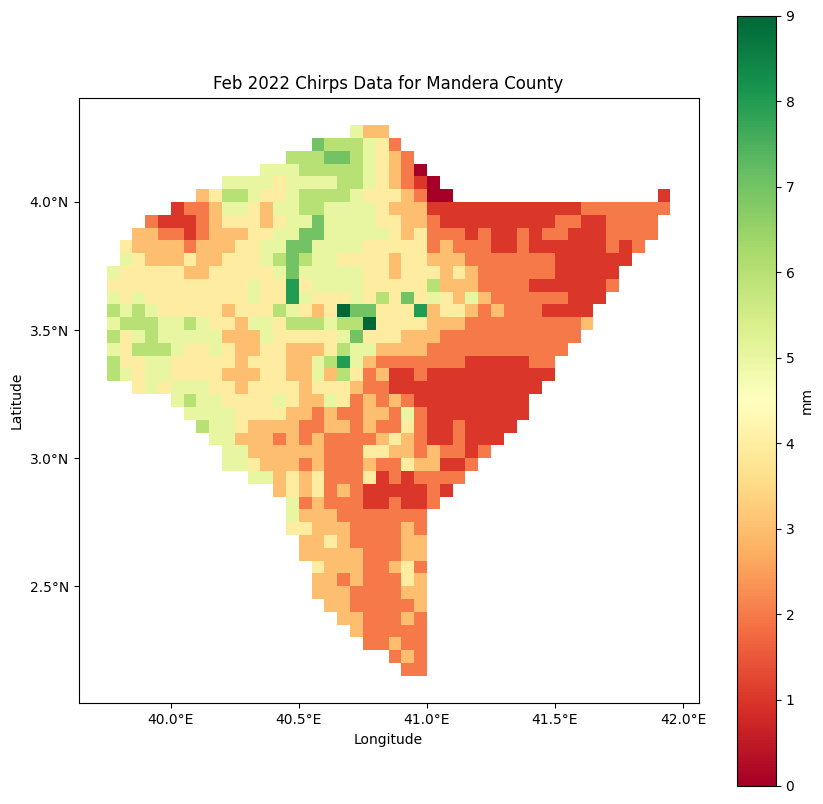

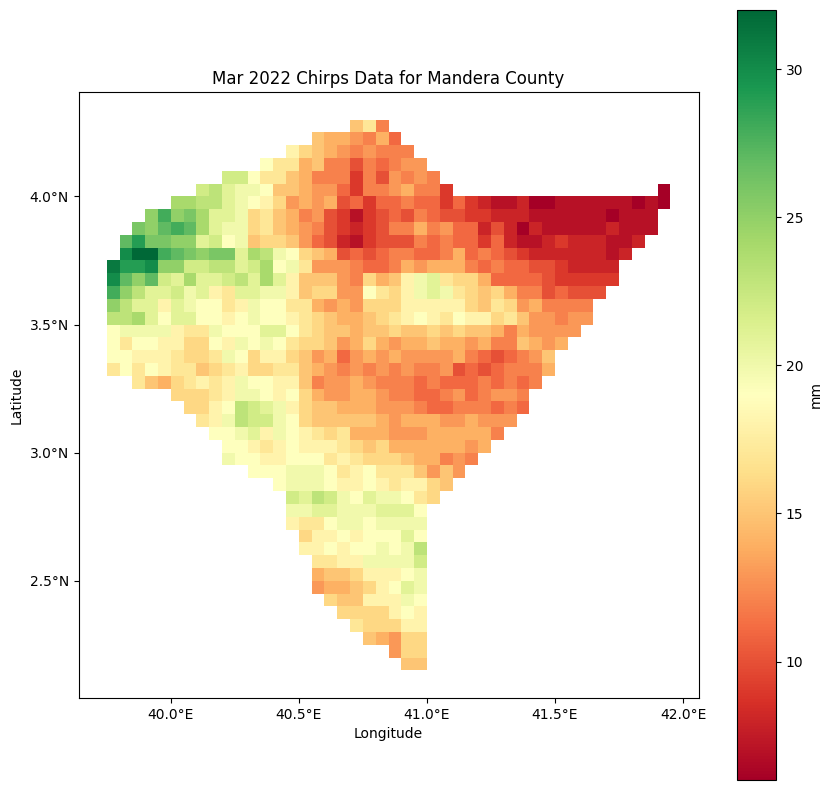

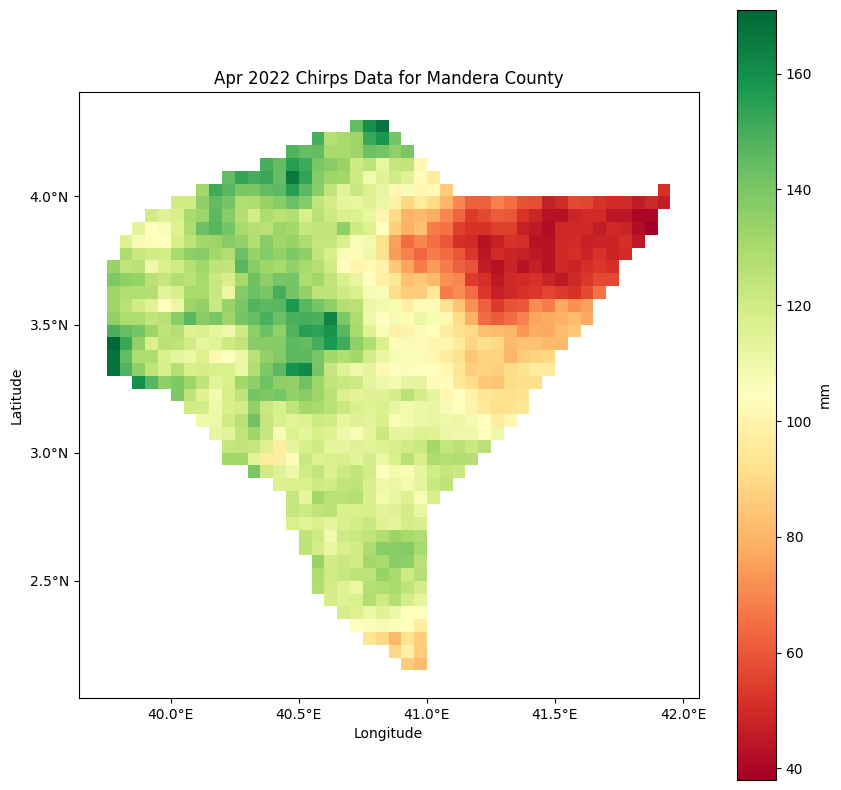

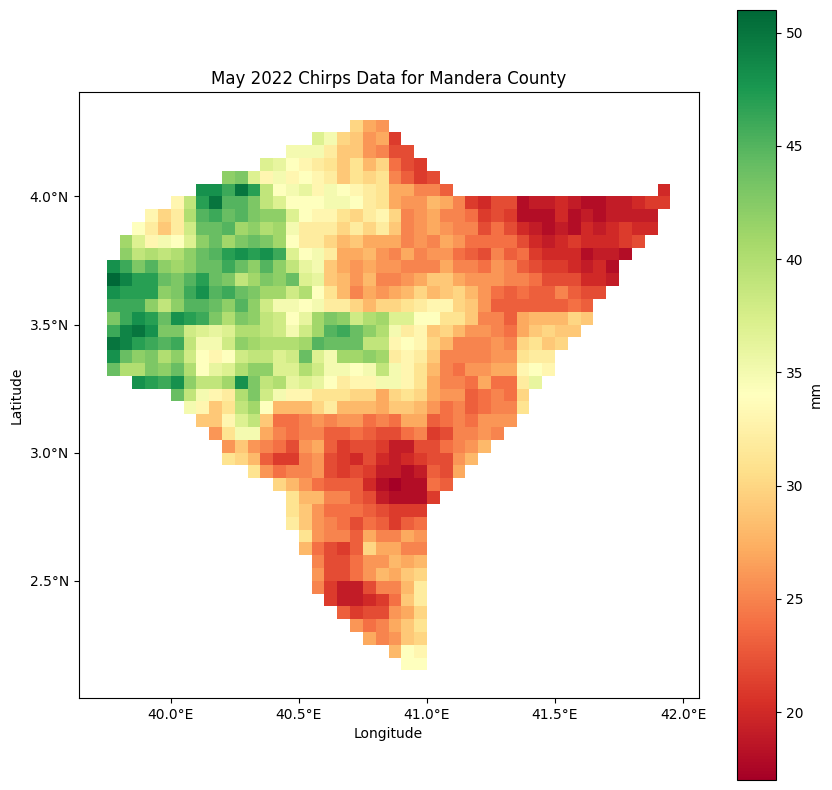

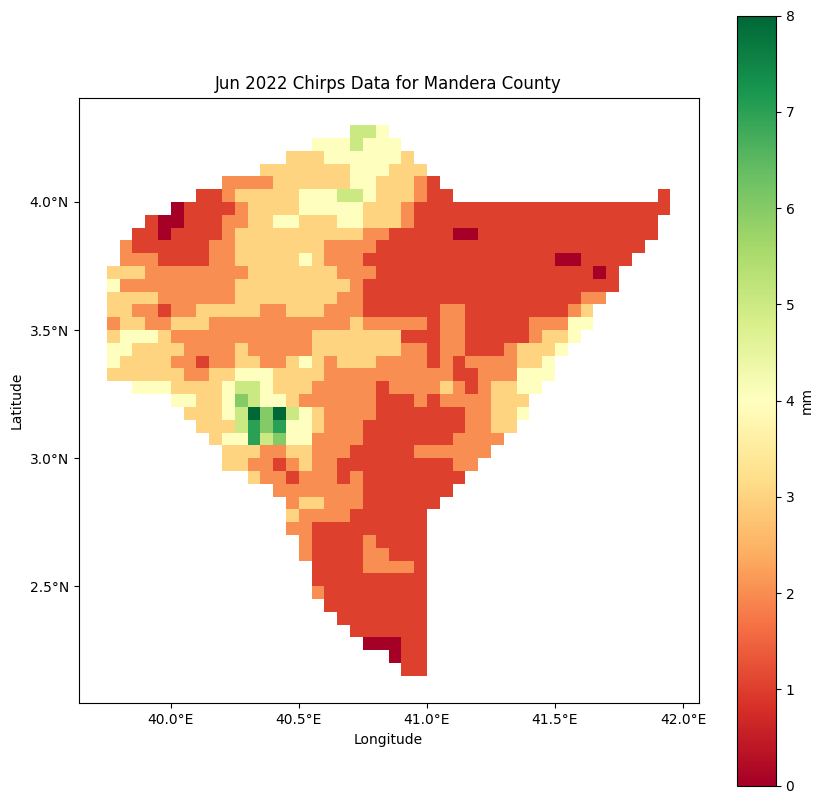

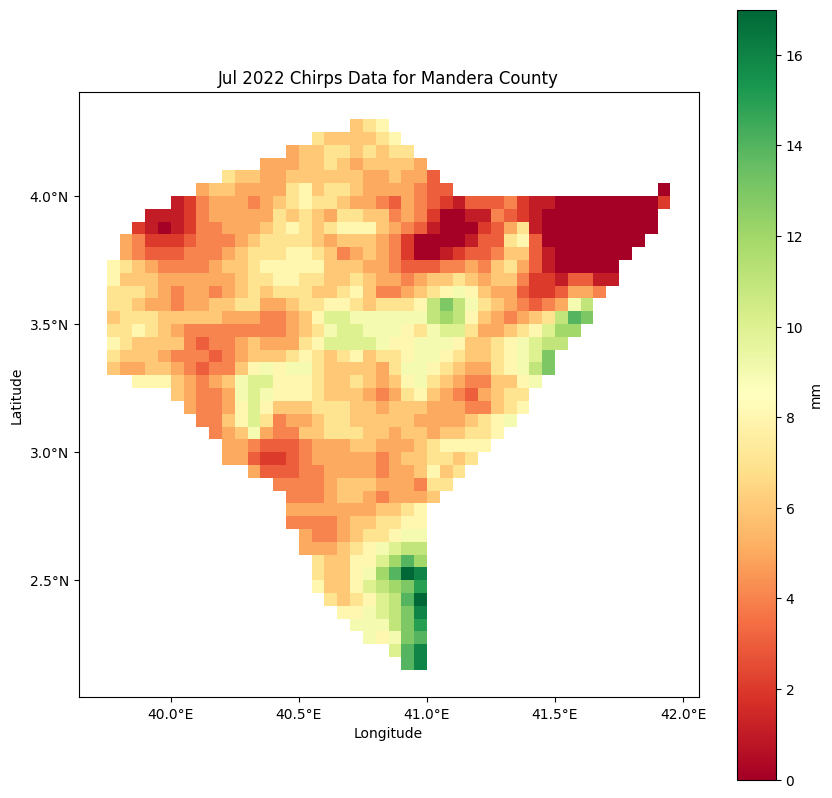

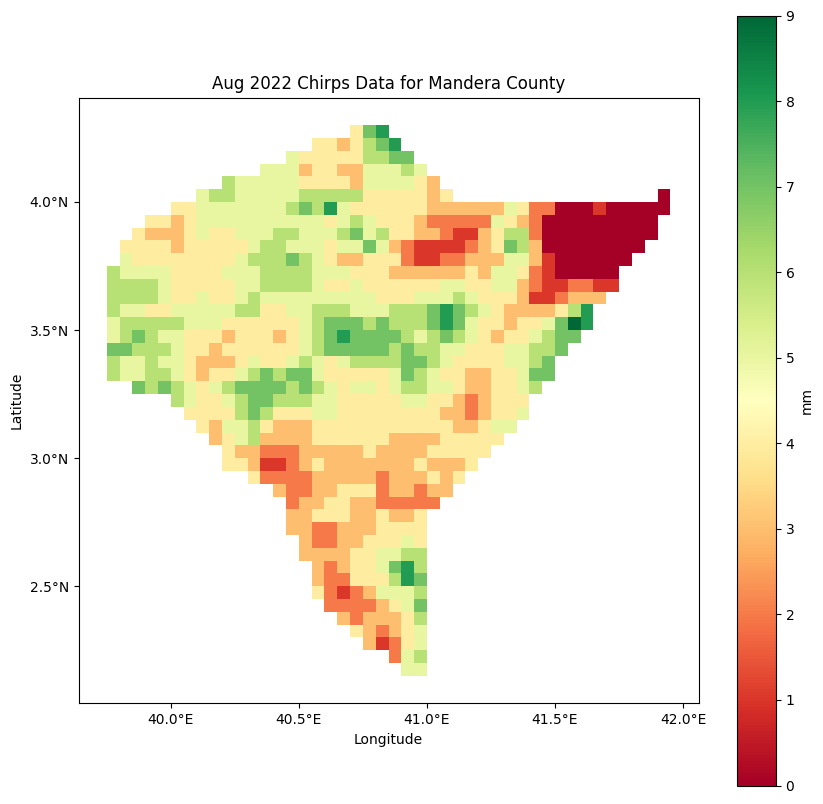

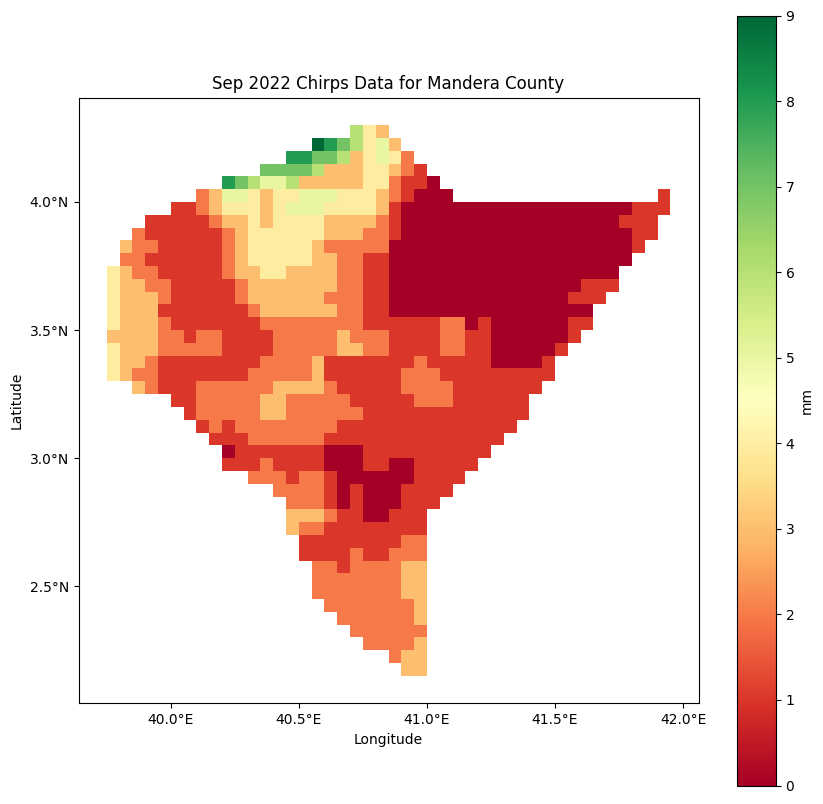

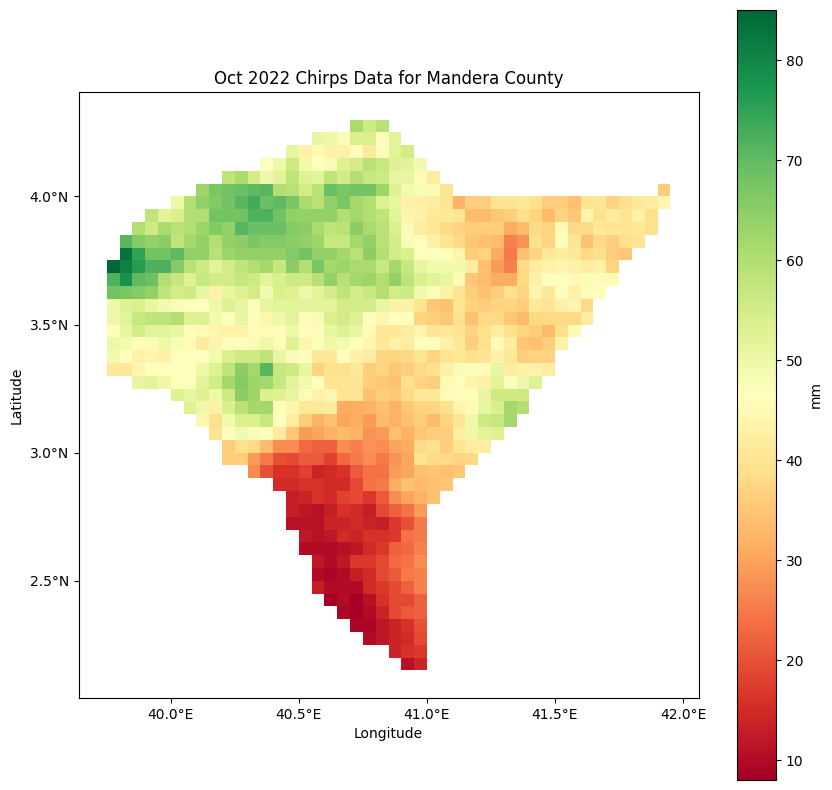

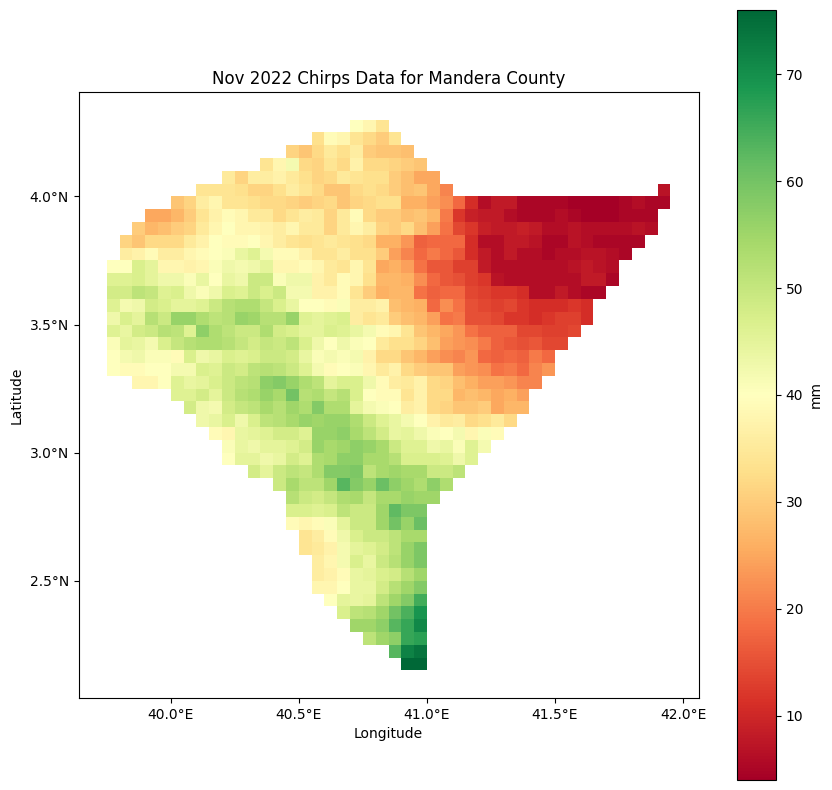

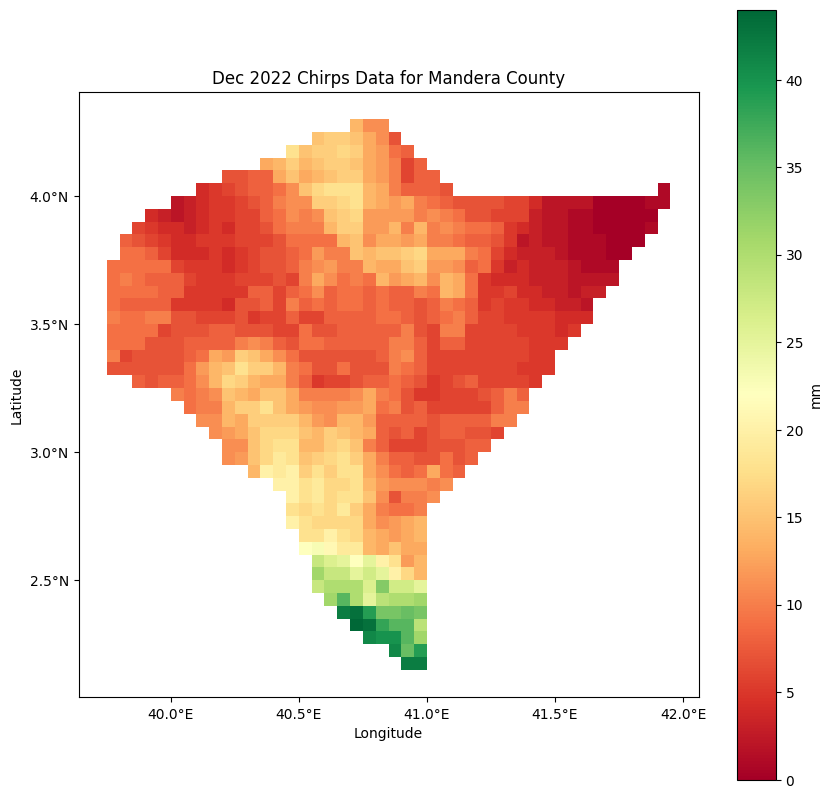

In [10]:
# Define a mapping of month numbers to month names
month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

# Loop through the months (from Jan to Dec)
for month_num in range(1, 13):
    # Set the year
    year = 2022
    
    # Get the name_1 value from the DataFrame
    name_1 = gdf['county_name'].iloc[3]

    # Dynamically select the column based on the month number
    month_column = f'final_{month_num:02}'  # Format month number to two digits
    
    # Get the month name from the mapping
    month_name = month_mapping[month_num]

    # Create a new figure and axis for each month
    ax = gdf.plot(column=month_column, cmap='RdYlGn', legend=True, legend_kwds={'label': "mm"}, figsize=(10, 10))
    
    # Set the title for the current month with the year and name_1
    ax.set_title(f'{month_name} {year} Chirps Data for {name_1} County', fontsize=12)
    
    # Set x and y axis labels with degrees and directions
    ax.set_xlabel('Longitude', fontsize=10)  # Example label, adjust as needed
    ax.set_ylabel('Latitude', fontsize=10)   # Example label, adjust as needed
    
    # Set x and y axis ticks with directions
    x_ticks = ax.get_xticks()
    x_tick_labels = [f'{tick:.1f}°E' if tick >= 0 else f'{abs(tick):.1f}°W' for tick in x_ticks]
    ax.set_xticklabels(x_tick_labels)
    
    y_ticks = ax.get_yticks()
    y_tick_labels = [f'{tick:.1f}°N' if tick >= 0 else f'{abs(tick):.1f}°S' for tick in y_ticks]
    ax.set_yticklabels(y_tick_labels)
    
    # Define the directory name
    directory_name = f'{name_1}_chirps_final'
    
    # Create the directory if it doesn't exist
    os.makedirs(directory_name, exist_ok=True)
    
    # Define the file name
    file_name = f'{directory_name}/{month_name}_{year}_chirps_data_for_{name_1}.png'
    
    # Save the plot as an image
    ax.figure.savefig(file_name, bbox_inches='tight', pad_inches=0)

In [12]:
# Set the resolution of the output GeoTIFF
resolution = (-0.005, 0.005)  # Adjust as needed

# Loop through the months (from Jan to Dec)
for month_num in range(1, 13):
    # Get the year from the first row of the DataFrame (assuming it's the same for all rows)
    year = 2022
    
    # Get the name_1 value from the first row of the DataFrame (assuming it's the same for all rows)
    name_1 = gdf['county_name'].iloc[0]
    
    # Create a GeoCube
    month_column = f'final_{month_num:02}'  # Format month number to two digits
    cube = make_geocube(vector_data=gdf, measurements=[month_column], resolution=resolution)

    # Convert cube to xarray Dataset
    ds = cube.squeeze()

    # Define the directory name
    directory_name = f'{name_1}_chirps_tiff_files'
    
    # Create the directory if it doesn't exist
    os.makedirs(directory_name, exist_ok=True)

    # Export GeoTIFF
    output_tiff_path = f'{directory_name}/{name_1}_{month_column}_{year}_chirps.tiff'
    ds.rio.to_raster(output_tiff_path, driver='GTiff')